In [41]:
import json
import os

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [42]:
def load_data(directory: str):
    all_paths = []
    for path in os.listdir(directory):
        if not os.path.isdir(directory + "/" + path):
            all_paths.append(directory + "/" + path)
            
    all_data = []
    for path in all_paths:
        with open(path, "r") as f:
            data = json.load(f)
            all_data.append(data)
            
    return all_data

In [43]:
def get_data_frame(data):
    frame = {
        "Image": dict(),
        "Winner": dict(),
        "Loser": dict(),
    }
    
    i = 0
    for entry in data:
        for task in entry:
            if task["choice"] is None:
                continue
            
            frame["Winner"][i] = task["left"] if task["choice"] == 0 else task["right"]
            frame["Loser"][i] = task["left"] if task["choice"] == 1 else task["right"]
            frame["Image"][i] = task["id"]
            i += 1
            
    return pd.DataFrame(frame)

In [44]:
def get_winrate(df: pd.DataFrame, labels):
    win_frame = df.pivot(columns=["Loser"], values=["Winner"])  # Winners to Loser columns
    win_frame = win_frame.droplevel(0, axis="columns")          # Clean column names
    win_frame = win_frame.reindex(labels, axis="columns")       # Sort columns
    win_frame = win_frame.notna()                               # To boolean
    win_frame.index = win_frame.index.map(df["Winner"])         # Label indices
    
    win_mat = win_frame.groupby(win_frame.index).sum()          # Aggregate columns to win count
    cnt_mat = win_mat + win_mat.T                               # Count total matches
    prb_mat = win_mat / cnt_mat                                 # Get probability
    
    return prb_mat

In [45]:
def get_p_matrix(df: pd.DataFrame, labels):
    win_frame = df.pivot(columns=["Loser"], values=["Winner"])  # Winners to Loser columns
    win_frame = win_frame.droplevel(0, axis="columns")          # Clean column names
    win_frame = win_frame.reindex(labels, axis="columns")       # Sort columns
    win_frame = win_frame.notna()                               # To boolean
    win_frame.index = win_frame.index.map(df["Winner"])        # Label indices
    
    win_mat = win_frame.groupby(win_frame.index).sum()         # Aggregate columns to win count
    cnt_mat = win_mat + win_mat.T                               # Count total matches
    
    return win_mat.combine(cnt_mat, lambda ss, ns: ss.combine(ns, lambda s, n: stats.binomtest(int(s), n, p=0.5).pvalue))

In [46]:
def get_p_ranks(df: pd.DataFrame, ranks: pd.Series):
    win_frame = df.pivot(columns=["Loser"], values=["Winner"])  # Winners to Loser columns
    win_frame = win_frame.droplevel(0, axis="columns")          # Clean column names
    win_frame = win_frame.reindex(labels, axis="columns")       # Sort columns
    win_frame = win_frame.notna()                               # To boolean
    win_frame.index = win_frame.index.map(df["Winner"])         # Label indices
    
    win_mat = win_frame.groupby(win_frame.index).sum()          # Aggregate columns to win count
    cnt_mat = (win_mat + win_mat.T)                             # Count total matches
    win_ser = win_mat.sum(axis="columns")
    cnt_ser = cnt_mat.sum(axis="columns")
    cnt_ser.index = ranks.index
    win_ser.index = ranks.index
    
    res = [[], []]
    for i in range(len(ranks)):
        if i - 1 >= 0:
            test = stats.binomtest(int(win_ser.iloc[i]), cnt_ser.iloc[i], p=ranks.iloc[i - 1], alternative="less")
            print(test.proportion_ci(confidence_level=0.9975).high - test.statistic)
            res[1].append(test.proportion_ci(confidence_level=0.9975).high - test.statistic)
        else:
            res[1].append(0)
        if i + 1< len(ranks):
            test = stats.binomtest(int(win_ser.iloc[i]), cnt_ser.iloc[i], p=ranks.iloc[i + 1], alternative="greater")
            res[0].append(test.statistic - test.proportion_ci(confidence_level=0.9975).low)
        else:
            res[0].append(0)
    
    return res

In [47]:
def get_algo_rate(df: pd.DataFrame, labels):
    win_frame = df.pivot(columns=["Winner"], values=["Image"])  # Winners to Loser columns
    win_frame = win_frame.droplevel(0, axis="columns")          # Clean column names
    win_frame = win_frame.reindex(labels, axis="columns")       # Sort columns
    win_frame = win_frame.notna()                               # To boolean
    win_frame.index = win_frame.index.map(df["Image"])          # Label indices
    
    win_mat = win_frame.groupby(win_frame.index).sum()          # Aggregate columns to win count
    prb_mat = win_mat               # Get probability
    
    return prb_mat

In [62]:
matplotlib.rcParams.update({'font.size': 7})

In [49]:
labels = ["fs", "fs-em", "zf", "zf-em", "x"]
images = [ "bedouin", "botanic", "calanque", "calculator", "carceri", "cd", "conch", "crypt", "ernte", "espinasse", "imaginary", "lines", "owls", "renoir", "sagarmatha", "snow", "text", "trefoil" ]

In [50]:
raw_data = load_data("./data")
frame = get_data_frame(raw_data)
frame

,Image,Winner,Loser
0,snow,fs-em,zf-em
1,sagarmatha,fs-em,zf-em
2,conch,zf,zf-em
3,renoir,x,zf
4,owls,fs-em,x
...,...,...,...
391,owls,x,x
392,lines,fs,x
393,owls,x,zf
394,bedouin,zf-em,zf-em


In [51]:
win_mat = get_winrate(frame, labels)
win_mat

,fs,fs-em,x,zf,zf-em
fs,0.500000,0.727273,0.594595,0.875000,0.851852
fs-em,0.272727,0.500000,0.533333,0.857143,0.685714
x,0.405405,0.466667,0.500000,0.848485,0.888889
zf,0.125000,0.142857,0.151515,0.500000,0.406250
zf-em,0.148148,0.314286,0.111111,0.593750,0.500000


In [52]:
img_mat = get_algo_rate(frame, labels)
img_mat

Winner,fs,fs-em,zf,zf-em,x
bedouin,3,5,0,6,6
botanic,8,3,2,5,3
calanque,6,5,1,4,5
calculator,6,5,2,1,8
carceri,4,7,4,2,3
cd,5,7,3,4,8
conch,5,5,7,2,7
crypt,8,2,3,4,5
ernte,5,9,1,1,5
espinasse,11,4,2,2,3


In [53]:
win_rank = win_mat.mean(axis="columns").rename("Column mean")
win_rank

fs       0.709744
fs-em    0.569784
x        0.621889
zf       0.265124
zf-em    0.333459
Name: Column mean, dtype: float64

In [54]:
p_matrix = get_p_matrix(frame, labels)
p_matrix

,fs,fs-em,x,zf,zf-em
fs,1.000000,0.013531,0.324009,0.000001,0.000311
fs-em,0.013531,1.000000,0.855536,0.000022,0.040960
x,0.324009,0.855536,1.000000,0.000066,0.000002
zf,0.000001,0.000022,0.000066,1.000000,0.377086
zf-em,0.000311,0.040960,0.000002,0.377086,1.000000


0.10863866582768666
0.10398570948364294
0.10621760531163807
0.11415168300741257


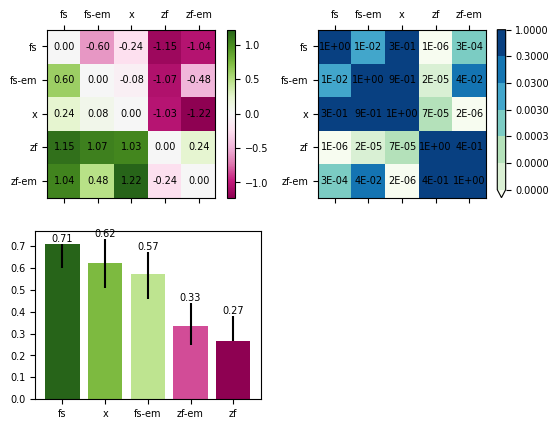

In [63]:
fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)

axis = np.arange(5)
ax.set_xticks(axis)
ax.set_yticks(axis)
ax.set_xticklabels(np.sort(labels))
ax.set_yticklabels(np.sort(labels))

z_mat = win_mat.T.apply(lambda x: stats.norm.ppf(x))
cax = ax.matshow(z_mat, cmap=plt.get_cmap("PiYG"))
fig.colorbar(cax)
for x in range(5):
    for y in range(5):
        c = z_mat[np.sort(labels)[x]][np.sort(labels)[y]]
        ax.text(x, y, f"{c:.2f}", va='center', ha='center')

ax = fig.add_subplot(2, 2, 2)

axis = np.arange(5)
ax.set_xticks(axis)
ax.set_yticks(axis)
ax.set_xticklabels(np.sort(labels))
ax.set_yticklabels(np.sort(labels))

bounds = [0.000003, 0.00003, 0.0003, 0.003, 0.03, 0.3, 1]
norm = matplotlib.colors.BoundaryNorm(bounds, plt.get_cmap("GnBu").N, extend='min')

cax = ax.matshow(p_matrix, cmap=plt.get_cmap("GnBu"), norm=norm)
fig.colorbar(cax)
for x in range(5):
    for y in range(5):
        c = p_matrix[np.sort(labels)[x]][np.sort(labels)[y]]
        ax.text(x, y, f"{c:.0E}", va='center', ha='center')

ax = fig.add_subplot(2, 2, 3)

win_rank_sorted = win_rank.sort_values(ascending=False)
axis = np.arange(5)
ax.set_xticks(axis)
ax.set_xticklabels(win_rank_sorted.index)

p_ranks = get_p_ranks(frame, win_rank_sorted)
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
cax = ax.bar(win_rank_sorted.index, win_rank_sorted, yerr=p_ranks ,color=plt.get_cmap("PiYG")(rescale(win_rank_sorted)))
ax.bar_label(cax, fmt="{0:.2f}")

# ax = fig.add_subplot(2, 2, 4)


# axis = np.arange(len(p_ranks.index))
# ax.set_xticks(axis)
# ax.set_xticklabels(p_ranks.index, rotation=90)
# 
# rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
# cax = ax.bar(p_ranks.index, p_ranks, color=plt.get_cmap("GnBu")(rescale(win_rank)))
# ax.bar_label(cax, fmt="{0:.2e}", rotation=90)

# plt.savefig("./plots/win_mat.svg")
plt.show()

In [56]:
image_frames = []
win_rates = []
win_ranks = []
for image in images:
    image_frame = frame.loc[frame["Image"] == image]
    image_win_rate = get_winrate(image_frame, labels)
    image_win_rank = image_win_rate.sum(axis="columns").rename("Score") / 4.5
    
    image_frames.append(image_frame)
    win_rates.append(image_win_rate)
    win_ranks.append(image_win_rank)

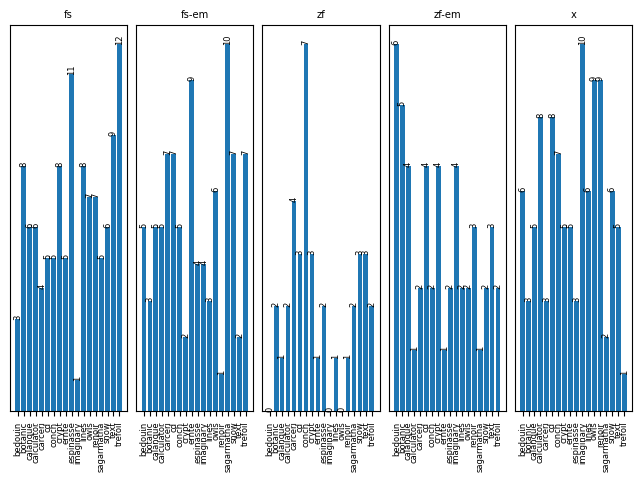

In [57]:
matplotlib.rcParams.update({'font.size': 6})

fig = plt.figure()

for i in range(len(labels)):
    
    ax = fig.add_subplot(1, 5, i + 1)
    ax.set_title(labels[i])
    
    axis = np.arange(len(img_mat.index))
    ax.set_xticks(axis)
    ax.set_yticks([])
    ax.set_xticklabels(img_mat.index, rotation=90)
    
    cax = ax.bar(img_mat.index, img_mat[labels[i]])
    ax.bar_label(cax, fmt="{0:.0f}", rotation=90)
    # plt.savefig("./plots/win_mat.svg")
    
plt.tight_layout()
plt.show()
# matrix